In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from typing import Tuple, Dict, List

import os
import ast
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from thor_magni_tools.utils.load import load_csv_metadata, preprocessing_header
from thor_magni_tools.preprocessing.filtering import Filterer3DOF
from thor_magni_tools.preprocessing import TrajectoriesReprocessor
from thor_magni_tools.utils.visualization_nb import visualize_scenario

In [2]:
DIR_PATH = "../datasets/thor_magni_zenodo/"
SCENARIO_ID = "Scenario_1"

In [3]:
files_list = os.listdir(os.path.join(DIR_PATH, SCENARIO_ID))
files_list

['THOR-Magni_180522_SC1B_R2.csv',
 'THOR-Magni_130522_SC1A_R1.csv',
 'THOR-Magni_120522_SC1B_R2.csv',
 'THOR-Magni_130522_SC1B_R1.csv',
 'THOR-Magni_180522_SC1B_R1.csv',
 'THOR-Magni_170522_SC1B_R2.csv',
 'THOR-Magni_130522_SC1A_R2.csv',
 'THOR-Magni_130522_SC1B_R2.csv',
 'THOR-Magni_180522_SC1A_R1.csv',
 'THOR-Magni_170522_SC1B_R1.csv',
 'THOR-Magni_120522_SC1A_R1.csv',
 'THOR-Magni_120522_SC1B_R1.csv',
 'THOR-Magni_180522_SC1A_R2.csv',
 'THOR-Magni_170522_SC1A_R1.csv',
 'THOR-Magni_170522_SC1A_R2.csv',
 'THOR-Magni_120522_SC1A_R2.csv']

In [6]:
raw_df, header_dict = load_csv_metadata(
    os.path.join(DIR_PATH, SCENARIO_ID, "THOR-Magni_170522_SC1B_R2.csv")
)
raw_df = raw_df.drop_duplicates("Frame")

In [7]:
new_header_dict = preprocessing_header(header_dict)
traj_metadata = new_header_dict["SENSOR_DATA"]["TRAJECTORIES"]["METADATA"]

# Filtering best markers

In [8]:
roles = {k: metadata["ROLE"] for k, metadata in traj_metadata.items()}
best_markers_traj = Filterer3DOF.filter_best_markers(raw_df, roles)

In [9]:
best_markers_traj[best_markers_traj.duplicated(subset=["frame_id", "x", "y", "z"])].dropna()

,frame_id,ag_id,x,y,z,data_label,marker_id
Time,,,,,,,


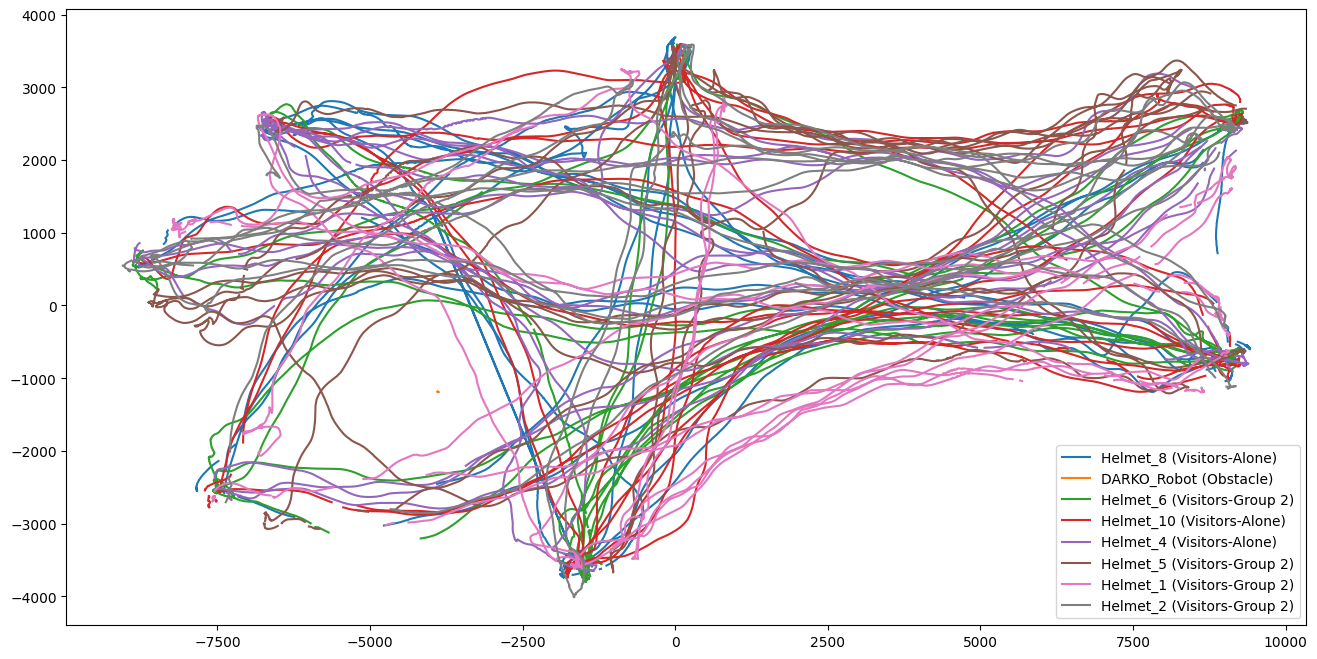

In [10]:
# Visualization
visualize_scenario(best_markers_traj, roles)

# Interpolating 1s

In [11]:
INTERPOLATION = 100

In [12]:
if INTERPOLATION:
    best_markers_traj = TrajectoriesReprocessor.reprocessing(
        best_markers_traj, 
        max_nans_interpolate=100, # max  1s interpolation
        resampling_rule=None,
        average_window=None,
    )  

# Tracking duration

Average until find an NaN value

In [13]:
if SCENARIO_ID == "Scenario_1":
    dynamic_agents_name = ("Helmet",)
if SCENARIO_ID in ["Scenario_2", "Scenario_3"]:
    dynamic_agents_name = ("Helmet", "DARKO_Robot", "LO1")
if SCENARIO_ID in ["Scenario_4", "Scenario_5"]:
    dynamic_agents_name = ("Helmet", "DARKO_Robot")

In [14]:
dynamic_agents = best_markers_traj[best_markers_traj.ag_id.str.startswith(dynamic_agents_name)]

In [15]:
dynamic_agents

,frame_id,ag_id,x,y,z,data_label,marker_id
Time,,,,,,,
0.01,2,Helmet_8,-1613.389,-3543.957,1646.923,Visitors-Alone,4
0.01,2,Helmet_10,-61.150,3350.979,1510.422,Visitors-Alone,1
0.01,2,Helmet_4,NaN,NaN,NaN,Visitors-Alone,1
0.01,2,Helmet_2,-6691.771,1792.259,1872.702,Visitors-Group 2,2
0.01,2,Helmet_5,-6488.589,2383.874,1671.752,Visitors-Group 2,2
...,...,...,...,...,...,...,...
240.77,24078,Helmet_4,2556.224,2080.371,1836.529,Visitors-Alone,1
240.77,24078,Helmet_6,-3168.300,1558.592,2014.697,Visitors-Group 2,1
240.77,24078,Helmet_8,-3901.652,-2453.438,1841.619,Visitors-Alone,4


In [16]:
helmet_5 = dynamic_agents[dynamic_agents.ag_id == "Helmet_5"]

In [17]:
def get_continuous_tracking_durations(dynamic_agent_data: pd.DataFrame) -> List[float]:
    mask = dynamic_agent_data[["x", "y", "x"]].isna().any(axis=1)
    groups = (mask != mask.shift()).cumsum()
    groups_of_continuous_tracking = dynamic_agent_data.groupby(groups)
    continuous_tracking_durations = []
    tracking_cols = dynamic_agent_data.columns[
            dynamic_agent_data.columns.str.startswith(("x", "y", "z", "rot"))
        ].tolist()
    for _, group in groups_of_continuous_tracking:
        if group[tracking_cols].isna().any(axis=0).all():
            continue
        continuous_tracking_durations.append(group.index[-1] - group.index[0])
    return continuous_tracking_durations

All agents:

In [18]:
tracking_duration = {}
for ag_id in dynamic_agents.ag_id.unique():
    dynamic_object_data = dynamic_agents[dynamic_agents["ag_id"] == ag_id]
    continuous_tracking_durations = get_continuous_tracking_durations(dynamic_object_data)
    tracking_duration[ag_id] = continuous_tracking_durations

In [19]:
overall_tracking_durations =  []
for tracking_durations in tracking_duration.values():
    overall_tracking_durations.extend(tracking_durations)
len(overall_tracking_durations)

42

In [20]:
overall_tracking_durations = np.array(overall_tracking_durations)
overall_tracking_durations.mean(), overall_tracking_durations.std()

(38.28261904761905, 47.50451562794164)

In [21]:
overall_tracking_durations

array([5.1540e+01, 3.7120e+01, 1.4370e+01, 6.6000e-01, 1.8370e+01,
       3.0100e+00, 2.9930e+01, 7.2540e+01, 1.8970e+01, 2.0000e-01,
       8.4120e+01, 1.5040e+01, 7.7450e+01, 4.9000e-01, 3.4860e+01,
       1.5000e-01, 1.2450e+01, 1.2240e+01, 1.1930e+01, 3.8820e+01,
       5.5080e+01, 3.0340e+01, 3.4560e+01, 2.1650e+01, 1.7257e+02,
       1.0480e+01, 4.8620e+01, 1.5038e+02, 1.9890e+01, 6.6150e+01,
       3.3700e+00, 9.2100e+01, 2.4070e+01, 1.7100e+00, 1.4070e+01,
       1.6100e+00, 2.0400e+00, 1.6130e+01, 5.5960e+01, 1.3240e+01,
       2.2456e+02, 1.5030e+01])

# Motion Speed

In [22]:
from thor_magni_tools.analysis.features import SpatioTemporalFeatures

In [23]:
helmet_5

,frame_id,ag_id,x,y,z,data_label,marker_id
Time,,,,,,,
0.01,2,Helmet_5,-6488.589,2383.874,1671.752,Visitors-Group 2,2
0.02,3,Helmet_5,-6487.946,2383.907,1671.556,Visitors-Group 2,2
0.03,4,Helmet_5,-6495.099,2384.679,1670.975,Visitors-Group 2,2
0.04,5,Helmet_5,-6494.964,2384.691,1670.809,Visitors-Group 2,2
0.05,6,Helmet_5,-6496.016,2384.902,1670.502,Visitors-Group 2,2
...,...,...,...,...,...,...,...
240.73,24074,Helmet_5,1450.995,982.923,1869.257,Visitors-Group 2,2
240.74,24075,Helmet_5,1449.243,990.983,1870.156,Visitors-Group 2,2
240.75,24076,Helmet_5,1447.422,998.725,1870.923,Visitors-Group 2,2


In [24]:
helmet_5_speed = SpatioTemporalFeatures.get_speed(helmet_5)
helmet_5_speed[0]

,frame_id,ag_id,x,y,z,data_label,marker_id,n_deltas,x_delta,y_delta,speed,x_speed,y_speed
Time,,,,,,,,,,,,,
0.01,2,Helmet_5,-6488.589,2383.874,1671.752,Visitors-Group 2,2,0.000000,0.000,0.000,0.000000,0.0,0.0
0.02,3,Helmet_5,-6487.946,2383.907,1671.556,Visitors-Group 2,2,0.643846,0.643,0.033,64.384625,64.3,3.3
0.03,4,Helmet_5,-6495.099,2384.679,1670.975,Visitors-Group 2,2,7.194539,-7.153,0.772,719.453911,-715.3,77.2
0.04,5,Helmet_5,-6494.964,2384.691,1670.809,Visitors-Group 2,2,0.135532,0.135,0.012,13.553228,13.5,1.2
0.05,6,Helmet_5,-6496.016,2384.902,1670.502,Visitors-Group 2,2,1.072952,-1.052,0.211,107.295154,-105.2,21.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
240.73,24074,Helmet_5,1450.995,982.923,1869.257,Visitors-Group 2,2,8.337504,-1.618,8.179,833.750352,-161.8,817.9
240.74,24075,Helmet_5,1449.243,990.983,1870.156,Visitors-Group 2,2,8.248218,-1.752,8.060,824.821823,-175.2,806.0
240.75,24076,Helmet_5,1447.422,998.725,1870.923,Visitors-Group 2,2,7.953276,-1.821,7.742,795.327637,-182.1,774.2


In [25]:
helmet_5_curvature = SpatioTemporalFeatures.get_curvature(helmet_5_speed)
helmet_5_curvature[0]

,frame_id,ag_id,x,y,z,data_label,marker_id,n_deltas,x_delta,y_delta,speed,x_speed,y_speed,curvature
Time,,,,,,,,,,,,,,
0.01,2,Helmet_5,-6488.589,2383.874,1671.752,Visitors-Group 2,2,0.000000,0.000,0.000,0.000000,0.0,0.0,0.000000
0.02,3,Helmet_5,-6487.946,2383.907,1671.556,Visitors-Group 2,2,0.643846,0.643,0.033,64.384625,64.3,3.3,1.372140
0.03,4,Helmet_5,-6495.099,2384.679,1670.975,Visitors-Group 2,2,7.194539,-7.153,0.772,719.453911,-715.3,77.2,0.000728
0.04,5,Helmet_5,-6494.964,2384.691,1670.809,Visitors-Group 2,2,0.135532,0.135,0.012,13.553228,13.5,1.2,29.913931
0.05,6,Helmet_5,-6496.016,2384.902,1670.502,Visitors-Group 2,2,1.072952,-1.052,0.211,107.295154,-105.2,21.1,0.081977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240.73,24074,Helmet_5,1450.995,982.923,1869.257,Visitors-Group 2,2,8.337504,-1.618,8.179,833.750352,-161.8,817.9,0.001923
240.74,24075,Helmet_5,1449.243,990.983,1870.156,Visitors-Group 2,2,8.248218,-1.752,8.060,824.821823,-175.2,806.0,0.002140
240.75,24076,Helmet_5,1447.422,998.725,1870.923,Visitors-Group 2,2,7.953276,-1.821,7.742,795.327637,-182.1,774.2,0.001878


In [26]:
helmet_5_acceleration = SpatioTemporalFeatures.get_acceleration(helmet_5)

In [27]:
helmet_5_acceleration[0]["acceleration"].max()

363215.3781157087

In [28]:
helmet_5_acceleration[0]["acceleration"][helmet_5_acceleration[0]["acceleration"] == helmet_5_acceleration[0]["acceleration"].max()]

Time
74.54    363215.378116
Name: acceleration, dtype: float64

In [32]:
helmet_5_acceleration[0][helmet_5_acceleration[0].index >= 74.50].head(60)

,frame_id,ag_id,x,y,z,data_label,marker_id,n_deltas,x_delta,y_delta,speed,x_speed,y_speed,n_speed_deltas,acceleration,x_acceleration,y_acceleration
Time,,,,,,,,,,,,,,,,,
74.50,7451,Helmet_5,-4109.174,1994.3500,1857.866,Visitors-Group 2,2,11.445242,-11.386,-1.1630,1144.524202,-1138.6,-116.30,1.114271e+01,1.114271e+03,4.000000e+02,1.040000e+03
74.51,7452,Helmet_5,-4120.733,1993.2830,1856.355,Visitors-Group 2,2,11.608142,-11.559,-1.0670,1160.814240,-1155.9,-106.70,1.978510e+01,1.978510e+03,-1.730000e+03,9.600000e+02
74.52,7453,Helmet_5,-4132.462,1992.2470,1854.867,Visitors-Group 2,2,11.774665,-11.729,-1.0360,1177.466505,-1172.9,-103.60,1.728034e+01,1.728034e+03,-1.700000e+03,3.100000e+02
74.53,7454,Helmet_5,-4129.726,1980.5820,1854.397,Visitors-Group 2,2,11.981566,2.736,-11.6650,1198.156588,273.6,-1166.50,1.795026e+03,1.795026e+05,1.446500e+05,-1.062900e+05
74.54,7455,Helmet_5,-4156.340,1990.3140,1852.829,Visitors-Group 2,2,28.337551,-26.614,9.7320,2833.755141,-2661.4,973.20,3.632154e+03,3.632154e+05,-2.935000e+05,2.139700e+05
74.55,7456,Helmet_5,-4168.494,1989.4230,1852.297,Visitors-Group 2,2,12.186615,-12.154,-0.8910,1218.661549,-1215.4,-89.10,1.794268e+03,1.794268e+05,1.446000e+05,-1.062300e+05
74.56,7457,Helmet_5,-4180.633,1988.7210,1852.060,Visitors-Group 2,2,12.159281,-12.139,-0.7020,1215.928143,-1213.9,-70.20,1.895943e+01,1.895943e+03,1.500000e+02,1.890000e+03
74.57,7458,Helmet_5,-4192.840,1988.0690,1852.251,Visitors-Group 2,2,12.224400,-12.207,-0.6520,1222.439990,-1220.7,-65.20,8.440379e+00,8.440379e+02,-6.800000e+02,5.000000e+02
74.58,7459,Helmet_5,-4204.956,1987.7280,1852.675,Visitors-Group 2,2,12.120798,-12.116,-0.3410,1212.079770,-1211.6,-34.10,3.240401e+01,3.240401e+03,9.100000e+02,3.110000e+03
